# Carga de Datos

In [1]:
!wget https://www.dropbox.com/scl/fi/zscdwjrdmjlz9dg17nw4t/retina15.zip?rlkey=99usovljqa1ix8o9215eyep1t
!mv retina15.zip?rlkey=99usovljqa1ix8o9215eyep1t retina15.zip
!unzip -qq retina15.zip
!ls retina15

'wget' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


# Librerías y Funciones

In [2]:
import matplotlib.pylab as plt
import numpy as np
import cv2

from skimage.morphology import binary_dilation
from skimage.segmentation import clear_border,find_boundaries
from skimage.morphology import disk
from skimage.feature import canny

from skimage.measure import find_contours

from tqdm.auto import tqdm

c:\Users\river\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_img,echo='off'):
  # X = ImageLoad('retina15/img/img',i)        # carga imagen i en X
  # Y = ImageLoad('retina15/seg/seg',i)        # carga segmentacion i en Y
  st   = prefix + '_' + num2fixstr(num_img,2) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

def EdgeView(X,Ys,Y=[]):
  plt.figure(figsize=(15,15))
  plt.imshow(X,cmap='gray')

  cc = 'r'

  if len(Y)!=0:
    contours = find_contours(np.float32(Y), 0.5)
    for n, contour in enumerate(contours):
      plt.plot(contour[:, 1], contour[:, 0], color=cc, linewidth=3)
    cc = 'y'


  contours = find_contours(np.float32(Ys), 0.5)
  for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], color=cc, linewidth=3)

# Carga de imagen i

In [4]:
def plot(image_array, gray=True):
    plt.figure().set_figwidth(30)
    plt.grid(False)
    plt.axis('off')
    if gray:
        plt.imshow(image_array, cmap='gray')
    else:
        plt.imshow(image_array)
    plt.show()

def plot_all(image_array, gray=False):
    plt.figure().set_figwidth(30)
    plt.grid(False)
    plt.axis('off')
    if gray:
        plt.imshow(np.concatenate(image_array,axis=1), cmap='gray')
    else:
        plt.imshow(np.concatenate(image_array,axis=1))
    plt.show()

In [5]:
def Detections(Y,Ys):
  #GT = Y>128
  #D  = Ys>128
  GT = Y
  D  = Ys
  GTn = np.logical_not(GT)
  Dn  = np.logical_not(D)
  TP = np.sum(np.logical_and(GT ,D ))
  TN = np.sum(np.logical_and(GTn,Dn))
  FP = np.sum(np.logical_and(GTn,D ))
  FN = np.sum(np.logical_and(GT ,Dn ))
  return TP,TN,FP,FN

def RatesF1(TP,TN,FP,FN):
  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  F1 = 2*TP / (2*TP + FP + FN)
  return TPR,FPR,F1


def statisticsImage(segFunction,i):
  X  = ImageLoad('retina15/img/img',i)   # Input image
  Y  = ImageLoad('retina15/seg/seg',i)   # Ideal segmentation (ground truth)
  Ys = segFunction(X)                    # Real Segmentation
  (TP,TN,FP,FN) = Detections(Y,Ys)
  (TPR,FPR,F1)  = RatesF1(TP,TN,FP,FN)
  return TPR,FPR,F1

def statisticsAllImages(segFunction):
  (TP,TN,FP,FN) = (0,0,0,0)
  for k in tqdm(range(15)):
    i = k+1
    X  = ImageLoad('retina15/img/img',i)   # Input image
    Y  = ImageLoad('retina15/seg/seg',i)   # Ideal segmentation (ground truth)
    Ys = segFunction(X)
    (TPi,TNi,FPi,FNi) = Detections(Y,Ys)
    TP = TP+TPi
    TN = TN+TNi
    FP = FP+FPi
    FN = FN+FNi
  (TPR,FPR,F1)  = RatesF1(TP,TN,FP,FN)
  return TPR,FPR,F1

# Segmentación

In [29]:
def RetinaSegmentation(X):
    X = X[:,:,1]
    X -= np.min(X)
    X /= np.max(X)
    X *= 255
    X = X.astype(np.uint8)

    # Base
    base = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(12, 12)).apply(X)

    kernel = np.ones((9,9),np.uint8)
    base_ = (base - cv2.morphologyEx(base, cv2.MORPH_CLOSE, kernel).astype(np.float32))
    base_ -= np.min(base_)
    base_ /= np.max(base_)
    base_ = (0.0 < base_) * (base_ < 0.813)

    kernel = np.ones((7,7), np.uint8)
    mask = cv2.dilate(base, kernel, iterations=3)

    mask = mask > 0.17*np.max(mask)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.erode(mask.astype(np.uint8) ,kernel,iterations = 5)
    base = base_ * mask



    # Corners
    corners = cv2.ximgproc.RidgeDetectionFilter_create().getRidgeFilteredImage(X) > 0.7*np.max(X)

    kernel = np.ones((5,5),np.uint8)
    mask = cv2.dilate(X, kernel, iterations = 3)
    mask = mask > 0.13*np.max(mask)
    kernel = np.ones((7,7),np.uint8)
    mask = cv2.erode(mask.astype(np.uint8), kernel, iterations = 4)
    mask = cv2.blur(mask, (15, 15))
    kernel_1 = np.ones((17,17),np.uint8)
    mask2 = cv2.blur(cv2.dilate(X, kernel_1, iterations = 1),(15, 15)) <= 1*215
    corners = corners * mask * mask2

    contours, hierarchy = cv2.findContours(corners.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    out = np.ones(X.shape)

    for cont in contours:
        if cv2.contourArea(cont) > 20:
            cv2.drawContours(out, [cont], -1, 0, -1)

    corners = corners * np.abs(out - 1)




    # Clean
    kernels = [
        np.array([  [-1, -1, -1],
                    [-1,  1, -1],
                    [-1, -1, -1] ], dtype="int")
    ]

    for i in range(4): kernels.append(np.rot90(np.array([   [-1,  1, -1],
                                                            [-1,  1, -1],
                                                            [-1, -1, -1] ], dtype="int"), i))
    for i in range(4): kernels.append(np.rot90(np.array([   [ 1, -1, -1],
                                                            [-1,  1, -1],
                                                            [-1, -1, -1] ], dtype="int"), i))

    for _ in range(2): base = base - sum([cv2.morphologyEx(base, cv2.MORPH_HITMISS, n) for n in kernels])

    for _ in range(3): corners = corners - sum([cv2.morphologyEx(corners.astype(np.uint8), cv2.MORPH_HITMISS, n) for n in kernels])

    return (base + corners) > 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


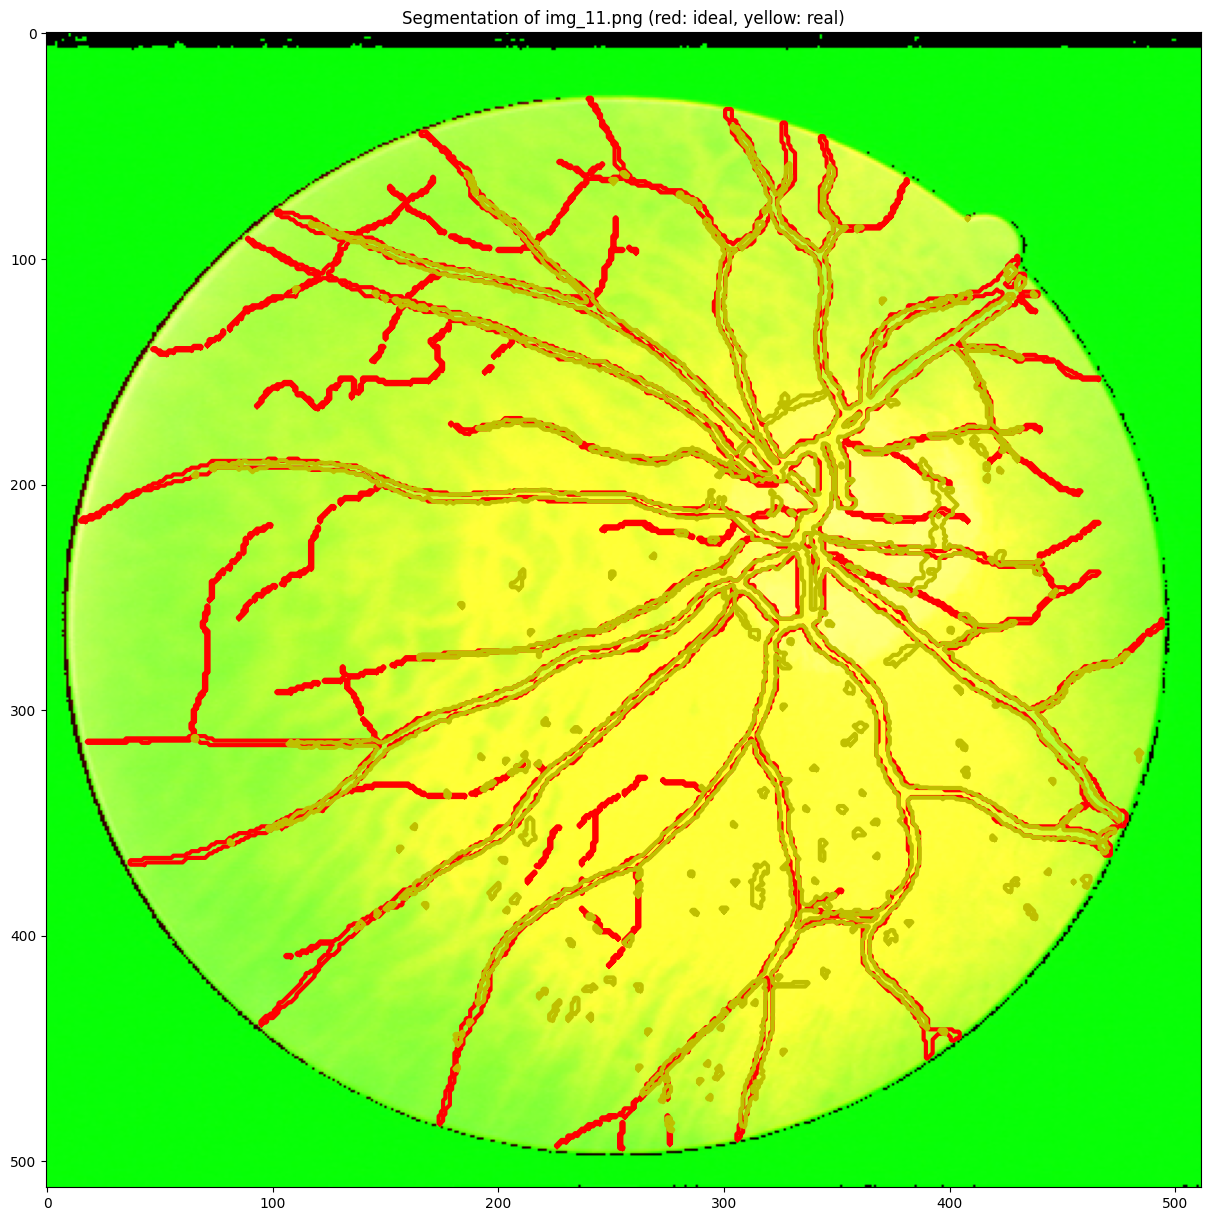

In [8]:
i = 11
# Color image
X = ImageLoad('retina15/img/img',i)

# Ideal Segmentation (Ground Truth)
Y = ImageLoad('retina15/seg/seg',i)

# Color + real and ideal Segmentation
# Ys = RetinaSegmentation3(X)
Ys = RetinaSegmentation(X)
EdgeView(X,Ys,Y)
plt.title('Segmentation of img_'+num2fixstr(i,2)+'.png (red: ideal, yellow: real)')
plt.show()


# Métricas estadísticas

## Funciones

## Estadísticas para imagen i

In [31]:
for i in range(1, 16):
    (TPR,FPR,F1)  = statisticsImage(RetinaSegmentation, i)
    print(i)
    print("TPR = {:.4f}".format(TPR))
    print("FPR = {:.4f}".format(FPR))
    print("F1  = {:.4f}".format(F1))
    print()

1
TPR = 0.7474
FPR = 0.0172
F1  = 0.7620

2
TPR = 0.6690
FPR = 0.0126
F1  = 0.7451

3
TPR = 0.7109
FPR = 0.0554
F1  = 0.5690

4
TPR = 0.6723
FPR = 0.0126
F1  = 0.7600

5
TPR = 0.5394
FPR = 0.0087
F1  = 0.6657

6
TPR = 0.6994
FPR = 0.0278
F1  = 0.6988

7
TPR = 0.6651
FPR = 0.0117
F1  = 0.7446

8
TPR = 0.7107
FPR = 0.0189
F1  = 0.7539

9
TPR = 0.6942
FPR = 0.0156
F1  = 0.7448

10
TPR = 0.7223
FPR = 0.0331
F1  = 0.6843

11
TPR = 0.6265
FPR = 0.0118
F1  = 0.6920

12
TPR = 0.7305
FPR = 0.0195
F1  = 0.7501

13
TPR = 0.7788
FPR = 0.0333
F1  = 0.7216

14
TPR = 0.6533
FPR = 0.0511
F1  = 0.6149

15
TPR = 0.7530
FPR = 0.0199
F1  = 0.7675



## Estadísticas para todas las imágenes


In [30]:
(TPR,FPR,F1) = statisticsAllImages(RetinaSegmentation)
print("TPR = {:.4f}".format(TPR))
print("FPR = {:.4f}".format(FPR))
print("F1  = {:.4f}".format(F1))

100%|██████████| 15/15 [00:00<00:00, 23.95it/s]

TPR = 0.6894
FPR = 0.0233
F1  = 0.7111
